In [23]:
import numpy as np
from AES_128_batch import *
from os import urandom
from tensorflow.keras.models import load_model
import time
from copy import deepcopy
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


def wrong_key_decryption(n, diff=0x80, nr=2,byte_index = None, net = None,key_index = None):
    
    bit_num = 16
    means = np.zeros(2**bit_num); 
    sig = np.zeros(2**bit_num);
    
    for subkey_diff_1 in  range(2**int(bit_num/2)):
        for subkey_diff_2 in range(2**int(bit_num/2)):
            
            keys = np.frombuffer(urandom(16*n), dtype=np.uint8).reshape(-1, 16)
            ks = key_expansion(keys, nr+1)
        
            pt0 = np.frombuffer(urandom(16*n), dtype=np.uint8).reshape(-1, 16)
            pt1 = pt0.copy();pt1[:, 0] ^= diff

            # 加密函数里调用了密钥扩展算法
            ct0 = aes_encrypt(pt0, keys, nr+1) # (n, 16)
            ct1 = aes_encrypt(pt1, keys, nr+1) # (n, 16)

            rsubkeys = deepcopy(ks[-1])

            # 注意密钥位置
            rsubkeys[:,int(key_index[0]%4),int(key_index[0]/4)] = rsubkeys[:,int(key_index[0]%4),int(key_index[0]/4)] ^ subkey_diff_1;
            rsubkeys[:,int(key_index[1]%4),int(key_index[1]/4)] = rsubkeys[:,int(key_index[1]%4),int(key_index[1]/4)] ^ subkey_diff_2;

            ct0_state = ct0.reshape(n,4,4).transpose((0, 2, 1))
            ct0_state = add_round_key(ct0_state, rsubkeys)
            # ct0_state = inv_mix_columns(ct0_state)
            ct0_state = inv_shift_rows(ct0_state)
            ct0_state = inv_sub_bytes(ct0_state) 
            ct0_state = ct0_state.transpose((0, 2, 1)).reshape(-1, 16)

            ct1_state = ct1.reshape(n,4,4).transpose((0, 2, 1))
            ct1_state = add_round_key(ct1_state, rsubkeys)
            # ct1_state = inv_mix_columns(ct1_state)
            ct1_state = inv_shift_rows(ct1_state)
            ct1_state = inv_sub_bytes(ct1_state)
            ct1_state = ct1_state.transpose((0, 2, 1)).reshape(-1, 16)

            # 抽取2个bytes数据
            byte_num = 2;i = byte_index
            ct0_state = ct0_state[:,i*byte_num:(i+1)*byte_num];
            ct1_state = ct1_state[:,i*byte_num:(i+1)*byte_num];
            raw_x = np.hstack((ct0_state, ct1_state))
            X = convert_to_binary(raw_x,byte_num)
            Z = net(X)

            Z = np.array(Z).flatten();
            index = subkey_diff_1+(subkey_diff_2<<int(bit_num/2))
            
            means[index] = np.mean(Z);
            sig[index] = np.std(Z);
        
    return(means, sig);

for byte_index in range(1,8):
    print("index = ",byte_index)
    file_and_key_index = [
        ["AES16_data_index_0_best_model_2r_depth5_num_epochs20_acc_0.9980679750442505.h5",[0,13]],
        ["AES16_data_index_1_best_model_2r_depth5_num_epochs20_acc_0.9980459809303284.h5",[10,7]],
        ["AES16_data_index_2_best_model_2r_depth5_num_epochs20_acc_0.9979869723320007.h5",[4,1]],
        ["AES16_data_index_3_best_model_2r_depth5_num_epochs20_acc_0.9981039762496948.h5",[14,11]],
        ["AES16_data_index_4_best_model_2r_depth5_num_epochs20_acc_0.9980419874191284.h5",[8,5]],
        ["AES16_data_index_5_best_model_2r_depth5_num_epochs20_acc_0.9980940222740173.h5",[2,15]],
        ["AES16_data_index_6_best_model_2r_depth5_num_epochs20_acc_0.9980159997940063.h5",[12,9]],
        ["AES16_data_index_7_best_model_2r_depth5_num_epochs20_acc_0.9980049729347229.h5",[6,3]]
    ]
    
    net = load_model(file_and_key_index[byte_index][0])
    nr = 2
    diff = 0x80
    n = 200
    m,s=wrong_key_decryption(n=n,diff=diff,nr=nr,byte_index = byte_index, net=net,key_index = file_and_key_index[byte_index][1])
    np.save("16bit_data_index_"+str(byte_index)+"_wrong_key_mean_"+str(nr)+"r.npy",m)
    np.save("16bit_data_index_"+str(byte_index)+"_wrong_key_std_"+str(nr)+"r.npy",s)

index =  1
index =  2
index =  3
index =  4
index =  5
index =  6
index =  7


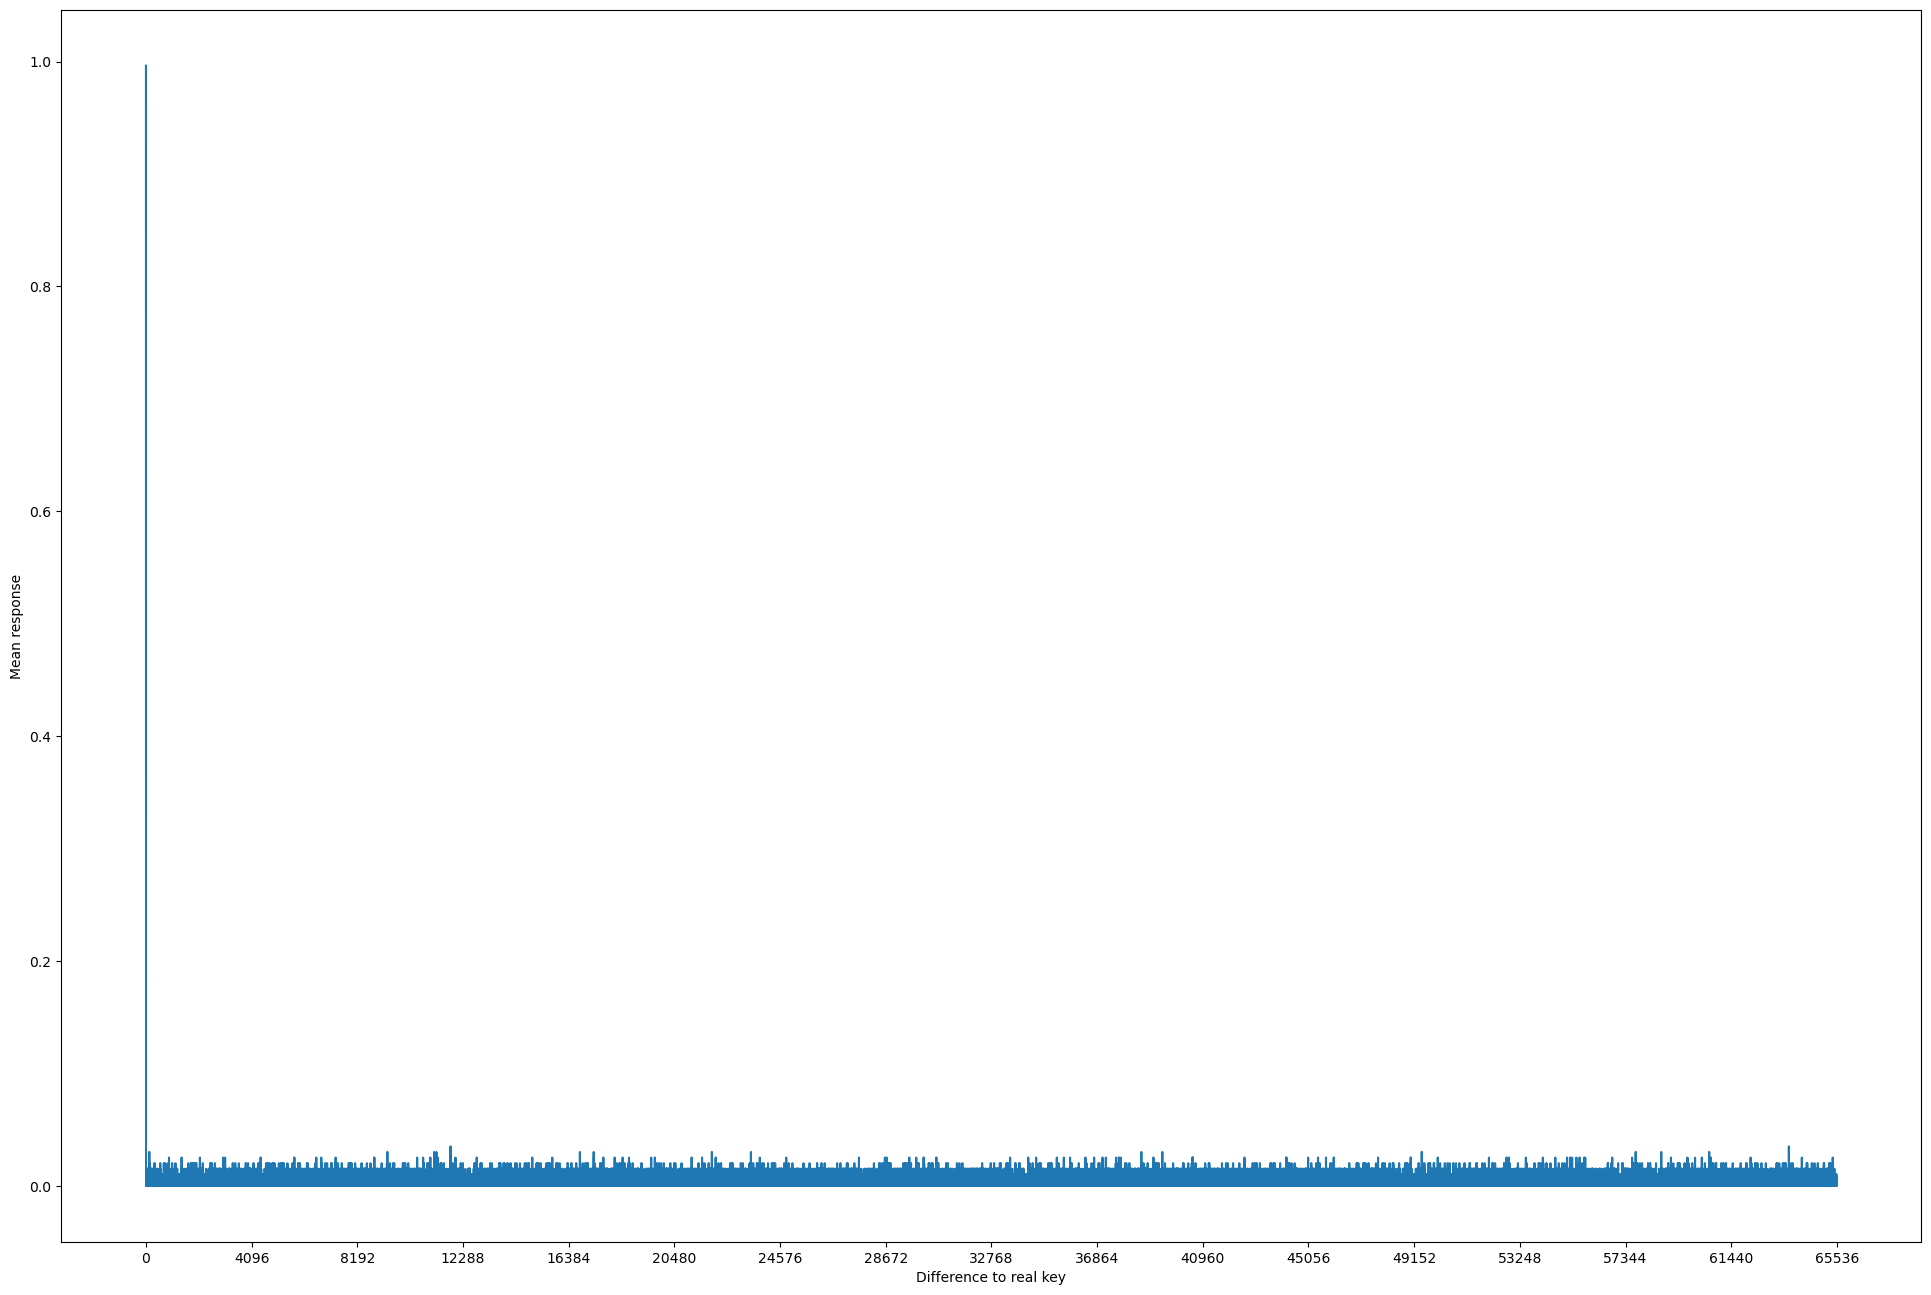

<Figure size 640x480 with 0 Axes>

In [22]:
import matplotlib.pyplot as plt
import numpy as np
bit_num = 16
index = 0
y = np.load("16bit_data_index_"+str(index)+"_wrong_key_mean_2r.npy")

plt.figure(figsize=(24,16))
plt.xticks(np.arange(0,2**bit_num+1,2**(bit_num-4)))
plt.xlabel('Difference to real key')
plt.ylabel('Mean response')
plt.plot(range(2**bit_num), y[:2**bit_num])
plt.show()
# plt.savefig('16bit_data_index_"+str(index)+"_wrong_key_mean_2r.png', dpi=300)
plt.savefig("16bit_data_index_"+str(index)+"_wrong_key_mean_2r.pdf", bbox_inches='tight')

In [7]:
import numpy as np
y = np.load("16bit_data_wrong_key_mean_2r.npy")
# print("len(y)=",len(y))
count_set=[]
for i in range(len(y)):
    if y[i] >= 0.99:
        count_set.append(str(bin(i)[2:].zfill(16)))
print("len(count_set) = ",len(count_set))
# for index in count_set:
#     print(index)
# 统计每个位置上0和1出现的次数
for i in range(16):
    num = 0
    for v in count_set:
        if v[15-i] == "0":
            num += 1
    print("Position {}".format(i),": 0s = {} , 1s = {}".format(num,len(count_set)-num))

len(count_set) =  256
Position 0 : 0s = 128 , 1s = 128
Position 1 : 0s = 128 , 1s = 128
Position 2 : 0s = 128 , 1s = 128
Position 3 : 0s = 128 , 1s = 128
Position 4 : 0s = 128 , 1s = 128
Position 5 : 0s = 128 , 1s = 128
Position 6 : 0s = 128 , 1s = 128
Position 7 : 0s = 128 , 1s = 128
Position 8 : 0s = 128 , 1s = 128
Position 9 : 0s = 128 , 1s = 128
Position 10 : 0s = 128 , 1s = 128
Position 11 : 0s = 128 , 1s = 128
Position 12 : 0s = 128 , 1s = 128
Position 13 : 0s = 128 , 1s = 128
Position 14 : 0s = 128 , 1s = 128
Position 15 : 0s = 128 , 1s = 128
